In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.style.use('ggplot')

In [2]:
GSPC = yf.download("^GSPC", start="1999-04-01", end="2019-10-09", interval = "1d")
VIX = yf.download("^VIX", start="1999-04-01", end="2019-10-09", interval = "1d")

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [3]:
GSPC_Close = GSPC[['Close']].values.astype(float)
VIX_Close = VIX[['Close']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
GSPC_scaled = min_max_scaler.fit_transform(GSPC_Close)
VIX_scaled = min_max_scaler.fit_transform(VIX_Close)

In [4]:
clean_data = pd.DataFrame(index=GSPC.index, data=GSPC_scaled, columns=['S&P500'])
clean_data['VIX'] = VIX_scaled

## Analyzed Periods

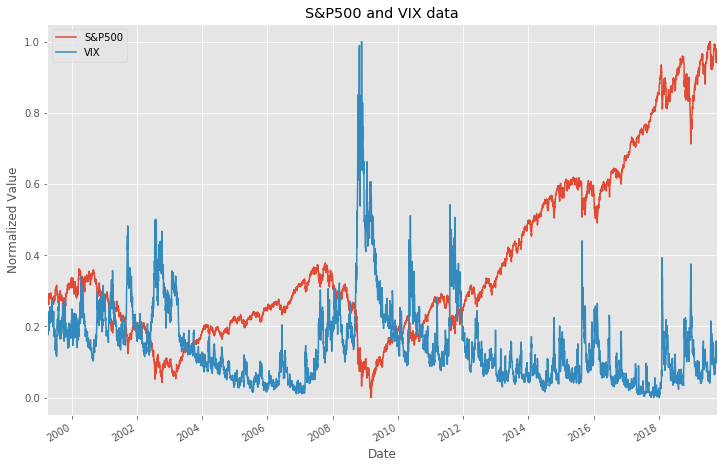

In [5]:
# Closing value of the S&P500 and VIX.
ax = clean_data.plot(figsize=(12,8), title = 'S&P500 and VIX data')
_ = ax.set_ylabel("Normalized Value")

In [6]:
train_GSPC_up = GSPC.loc['20030214':'20071009']
train_GSPC_down = GSPC.loc['20000901':'20030213']
test_GSPC_up = GSPC.loc['20090409':'20100326']
test_GSPC_down = GSPC.loc['20071009':'20080926']

train_VIX_up = VIX.loc['20030214':'20071009']
train_VIX_down = VIX.loc['20000901':'20030213']
test_VIX_up = VIX.loc['20090409':'20100326']
test_VIX_down = VIX.loc['20071009':'20080926']

## Quantitative Algorithms

In [7]:
def RSI(df, column="Close", period=14):
    # Wilder's RSI
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rUp = up.ewm(com=period - 1, adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
    rsi = 100 - 100 / (1 + rUp / rDown)
    df = df.join(rsi.to_frame('RSI'))
    df['RSI_p1'] = df['RSI'].shift()
    df['RSI_p2'] = df['RSI_p1'].shift()
    return df

In [8]:
def MACD(df, column="Close", fast=12, slow=26, line=9):
    exp1 = df[column].ewm(span=fast, adjust=False).mean()
    exp2 = df[column].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()
    df = df.join(macd.to_frame('MACD'))
    df['MACD_p1'] = df['MACD'].shift()
    df['MACD_p2'] = df['MACD_p1'].shift()
    return df

In [9]:
def ml_input(df, trend='up', types='train'):
    df1 = RSI(df)[['RSI', 'RSI_p1', 'RSI_p2']]
    df2 = MACD(df)[['MACD', 'MACD_p1', 'MACD_p2']]
    if trend=='up' and types =='train':
        df3 = train_VIX_up['Close']
    if trend=='down' and types =='train':
        df3 = train_VIX_down['Close']
    if trend=='up' and types =='test':
        df3 = test_VIX_up['Close']
    if trend=='down' and types =='test':
        df3 = test_VIX_down['Close']
    df1 = df1.join(df2)
    df1 = df1.join(df3)
    df1.rename(columns={"Close": "VIX"},inplace=True)
    df1['VIX_p1'] = df1['VIX'].shift()
    df1['VIX_p2'] = df1['VIX_p1'].shift()
    df1['S&P_change'] = df['Close'].diff()
    
    df1.drop(index=df1.index[:26], inplace=True)
    df1.drop(index=df1.index[-5:], inplace=True)

    return df1

In [10]:
def ml_output(data, shift_forward=5):
    df = data.copy()
    diff = (df['Close'].shift(-shift_forward) - df['Close'])
    df['Trading Signal'] = -1
    df.loc[diff>=0, 'Trading Signal'] = 1
    
    df.drop(index=df.index[:26], inplace=True)
    df.drop(index=df.index[-5:], inplace=True)
    
    return df[['Trading Signal']]

In [11]:
def rsi_cal(row):
    if row['RSI']<30:
        order = 1
    elif row['RSI']>70:
        order = -1
    else:
        order = 0
    return order

def macd_cal(row):
    if row['MACD']>0:
        order = 1
    elif row['MACD']<0:
        order = -1
    else:
        order = 0
    return order

def mom_cal(row):
    if row['Mom']<15:
        order = 1
    elif row['Mom']>85:
        order = -1
    else:
        order = 0
    return order


## Data

In [12]:
X_train_up = ml_input(train_GSPC_up)
y_train_up = ml_output(train_GSPC_up)
X_train_down = ml_input(train_GSPC_down, trend='down')
y_train_down = ml_output(train_GSPC_down)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
n_trees = 100

rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)

In [15]:
rf.fit(X_train_up.values, y_train_up.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
prob = rf.predict_proba(X_train_up.values)

In [17]:
rf.classes_

array([-1,  1])

In [18]:
purchase_TH = 0.55
sale_TH = 0.30

In [19]:
X_train_up_pred = rf.predict(X_train_up.values)

X_test_up = ml_input(test_GSPC_up, types='test')
y_test_up = ml_output(test_GSPC_up)

X_test_up_pred_rf = rf.predict(X_test_up.values)

## SVM

In [20]:
from sklearn.svm import SVC

In [21]:
kernel = 'rbf'
C = 100
gamma = 0.0001

svm = SVC(kernel=kernel, C=C, gamma=gamma, probability=True)

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(X_train_up.values)
distances = np.column_stack([np.sum((X_train_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [23]:
svm.fit(distances, y_train_up.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
kmeans = KMeans(n_clusters=6).fit(X_test_up.values)
distances = np.column_stack([np.sum((X_test_up.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [25]:
X_test_up_pred_svm = svm.predict(distances)

## Other indicators

In [26]:
X_up = X_test_up.copy(deep=True)

In [27]:
test_GSPC_up.loc[:,'Close_p12'] = test_GSPC_up['Close'].shift(12)
test_GSPC_up.loc[:,'Mom'] = test_GSPC_up['Close']-test_GSPC_up['Close_p12']
test_GSPC_up.drop(index=test_GSPC_up.index[:26], inplace=True)
test_GSPC_up.drop(index=test_GSPC_up.index[-5:], inplace=True)

/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [28]:
X_up['RSI_order'] = X_up.apply(rsi_cal, axis=1)
X_up['MACD_order'] = X_up.apply(macd_cal, axis=1)
X_up['Mom_order'] = test_GSPC_up.apply(mom_cal, axis=1)

In [29]:
X_up.describe()

,RSI,RSI_p1,RSI_p2,MACD,MACD_p1,MACD_p2,VIX,VIX_p1,VIX_p2,S&P_change,RSI_order,MACD_order,Mom_order
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,57.522228,57.439924,57.348275,8.101091,8.074270,8.055637,24.123585,24.199764,24.269340,1.306698,-0.089623,0.660377,0.433962
std,9.640769,9.613645,9.537998,8.331176,8.314085,8.299904,3.772035,3.789917,3.785496,11.096311,0.286316,0.752711,0.533590
min,33.301494,33.301494,33.301494,-14.388915,-14.388915,-14.388915,16.620000,16.620000,16.910000,-34.170000,-1.000000,-1.000000,-1.000000
25%,51.804318,51.804318,51.804318,3.683327,3.683327,3.683327,21.490000,21.565000,21.597500,-3.532500,0.000000,1.000000,0.000000
50%,58.791758,58.686446,58.597220,9.467833,9.467833,9.467833,24.255000,24.275000,24.295000,2.425000,0.000000,1.000000,0.000000
75%,64.131724,63.864467,63.769829,14.220439,14.150272,14.003161,26.127500,26.190000,26.230000,7.670000,0.000000,1.000000,1.000000
max,75.801736,75.801736,75.801736,23.131008,23.131008,23.131008,32.680000,33.120000,33.120000,26.840000,0.000000,1.000000,1.000000


In [62]:
X_down

,RSI,RSI_p1,RSI_p2,MACD,MACD_p1,MACD_p2,VIX,VIX_p1,VIX_p2,S&P_change,RSI_order,MACD_order,Mom_order
Date,,,,,,,,,,,,,
2007-11-14,38.267986,40.344663,25.289451,-21.845121,-21.936921,-22.801046,25.94,24.10,31.09,-10.47,0,-1,1
2007-11-15,34.698510,38.267986,40.344663,-23.074221,-21.845121,-21.936921,28.06,25.94,24.10,-19.43,0,-1,1
2007-11-16,37.164152,34.698510,38.267986,-23.168767,-23.074221,-21.845121,25.49,28.06,25.94,7.59,0,-1,1
2007-11-19,32.701921,37.164152,34.698510,-25.010606,-23.168767,-23.074221,26.01,25.49,28.06,-25.47,0,-1,1
2007-11-20,34.829309,32.701921,37.164152,-25.655685,-25.010606,-23.168767,24.88,26.01,25.49,6.43,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-15,35.713365,46.498818,45.816346,-13.786845,-9.488376,-9.871226,31.70,25.66,24.39,-59.00,0,-1,1
2008-09-16,40.939411,35.713365,46.498818,-15.330241,-13.786845,-9.488376,30.30,31.70,25.66,20.90,0,-1,1
2008-09-17,33.025190,40.939411,35.713365,-20.928510,-15.330241,-13.786845,36.22,30.30,31.70,-57.21,0,-1,1


## Backtester

In [31]:
def backtester(prices, orders, trend='up', initial_cap=10000, commission=0.0035):
    position = 0
    shares = 0
    capital = initial_cap
    capital_list = []
    
    if trend == 'up':

        for order, price in zip(orders, prices):
            if order == 1 and position == 0:
                position = 1
                capital = capital * (1 - commission)
                shares = capital / price[0]
            elif order == -1 and position == 1:
                position = 0
                capital = shares * price[0] * (1 - commission)
                shares = 0
            else:
                position = position
                shares = shares
                if shares != 0:
                    capital = shares * price[1]
                else:
                    capital = capital
                
#             if order == 1 and position == 0:
#                 position = 1
#                 capital = capital * (1 - commission)
#                 shares = capital / price[0]

#             elif order == 1 and position == 1:
#                 capital = shares * price[1]

#             elif order == -1 and position == 1:
#                 position = 0
#                 capital = shares * price[1] * (1 - commission)
#                 shares = 0

#             elif order == -1 and position == 0:
#                 capital = capital

            capital_list.append(capital)
    
    if trend == 'down':

        for order, price in zip(orders, prices):

            if order == -1 and position == 0:
                position = -1
                shares = capital / price[0]
                stock_values = shares * price[0] * (1 - commission)
                capital = capital + stock_values - shares * price[1]
                price_p = price[1]

            elif order == -1 and position == -1:
                #stocks_value = shares * price[1]
                #capital = capital + stock_values - shares * price[1]
                capital = capital - shares * (price[1]-price_p)
                price_p = price[1]
                shares = shares

            elif order == 1 and position == -1:
                position = 0
                stock_values = shares * price[0] * (1 - commission)
                #capital = capital + stock_values - shares * price[1]
                capital = capital + stock_values - shares * price[0]
                shares = 0
                price_p = price[1]

            elif order == 1 and position == 0:
                position = 1
                capital = capital * (1 - commission)
                shares = capital / price[0]
                price_p = price[1]
                
            elif order == -1 and position == 1:
                position = 0
                capital = shares * price[0] * (1 - commission)
                shares = 0
                price_p = price[1]
            else:
                position = position
                shares = shares
                if position > 0:
                    capital = shares * price[1]
                else:
                    capital = capital
                price_p = price[1]

            capital_list.append(capital)
    
    return capital_list

In [32]:
prices = test_GSPC_up[['Open', 'Close']]
prices.drop(index=prices.index[:26], inplace=True)
prices.drop(index=prices.index[-5:], inplace=True)

In [33]:
rf_orders = X_test_up_pred_rf
svm_orders = X_test_up_pred_svm

In [34]:
rsi_orders = X_up['RSI_order'].values
macd_orders = X_up['MACD_order'].values
mom_orders = X_up['Mom_order'].values

In [35]:
rf_capitals = backtester(prices.values, rf_orders, trend='up')
svm_capitals = backtester(prices.values, svm_orders, trend='up')

In [36]:
mom_capitals = backtester(prices.values, mom_orders, trend='up')
macd_capitals = backtester(prices.values, macd_orders, trend='up')
rsi_capitals = backtester(prices.values, rsi_orders, trend='up')

In [37]:
mom_orders

array([ 0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [38]:
BH_capitals = backtester(prices.values, np.ones(rf_orders.shape), trend='up')

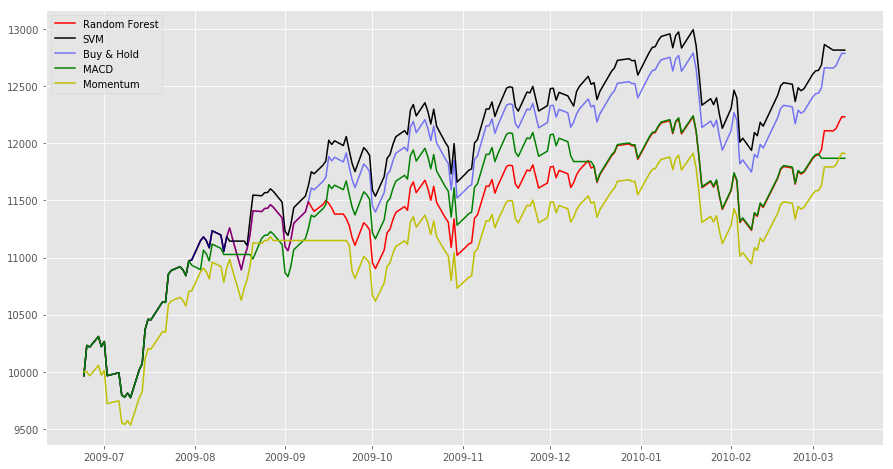

In [39]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(prices.index, rf_capitals, label='Random Forest', color='r')
_ = plt.plot(prices.index, svm_capitals, label='SVM', color='k')
_ = plt.plot(prices.index, BH_capitals, label='Buy & Hold', color='b', alpha=0.5)
_ = plt.plot(prices.index, macd_capitals, label='MACD', color='g')
_ = plt.plot(prices.index, mom_capitals, label='Momentum', color='y')
_ = plt.legend()

In [40]:
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3, random_state=42)
rf.fit(X_train_down.values, y_train_down.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
prob = rf.predict_proba(X_train_down.values)
X_train_down_pred = rf.predict(X_train_down.values)
X_test_down = ml_input(test_GSPC_down, trend='down', types='test')
y_test_down = ml_output(test_GSPC_down)

X_test_down_pred_rf = rf.predict(X_test_down.values)

In [42]:
svm = SVC(kernel=kernel, C=C, gamma=0.0000001, probability=True)
kmeans = KMeans(n_clusters=6).fit(X_train_down.values)
distances = np.column_stack([np.sum((X_train_down.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [43]:
svm.fit(distances, y_train_down.values.ravel())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
kmeans = KMeans(n_clusters=6).fit(X_test_down.values)
distances = np.column_stack([np.sum((X_test_down.values - center)**2, axis=1)**0.5 for center in kmeans.cluster_centers_])

In [45]:
X_test_down_pred_svm = svm.predict(distances)

In [46]:
X_down = X_test_down.copy(deep=True)
test_GSPC_down.loc[:,'Close_p12'] = test_GSPC_down['Close'].shift(12)
test_GSPC_down.loc[:,'Mom'] = test_GSPC_down['Close']-test_GSPC_down['Close_p12']
test_GSPC_down.drop(index=test_GSPC_down.index[:26], inplace=True)
test_GSPC_down.drop(index=test_GSPC_down.index[-5:], inplace=True)

/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/gabywang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [47]:
X_down['RSI_order'] = X_down.apply(rsi_cal, axis=1)
X_down['MACD_order'] = X_down.apply(macd_cal, axis=1)
X_down['Mom_order'] = test_GSPC_down.apply(mom_cal, axis=1)

In [48]:
prices = test_GSPC_down[['Open', 'Close']]
prices.drop(index=prices.index[:26], inplace=True)
prices.drop(index=prices.index[-5:], inplace=True)

In [49]:
rf_orders = X_test_down_pred_rf
svm_orders = X_test_down_pred_svm

In [50]:
#mom_orders = X_up['M_order'].values
macd_orders = X_down['MACD_order'].values
mom_orders = X_down['Mom_order'].values

In [51]:
mom_capitals = backtester(prices.values, mom_orders, trend='down')
macd_capitals = backtester(prices.values, macd_orders, trend='down')

In [52]:
rf_capitals = backtester(prices.values, rf_orders, trend='down')
svm_capitals = backtester(prices.values, svm_orders, trend='down')

In [53]:
BH_capitals = backtester(prices.values, np.ones(rf_orders.shape), trend='down')

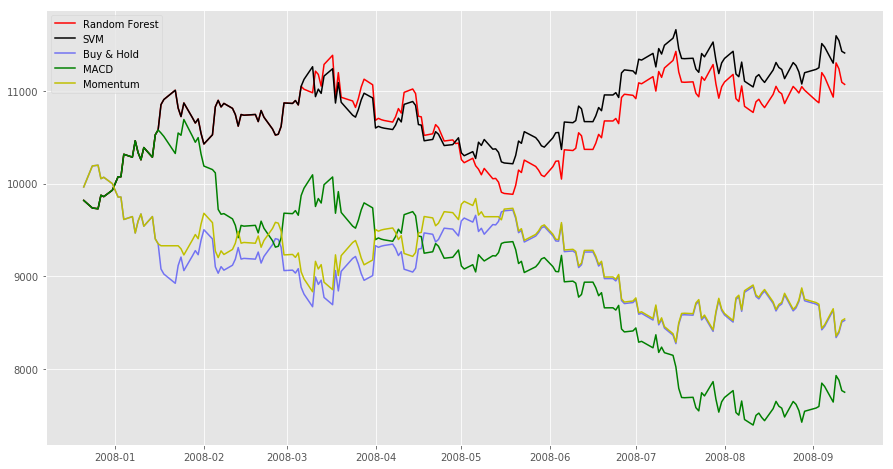

In [54]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(prices.index, rf_capitals, label='Random Forest', color='r')
_ = plt.plot(prices.index, svm_capitals, label='SVM', color='k')
_ = plt.plot(prices.index, BH_capitals, label='Buy & Hold', color='b', alpha=0.5)
_ = plt.plot(prices.index, macd_capitals, label='MACD', color='g')
_ = plt.plot(prices.index, mom_capitals, label='Momentum', color='y')
_ = plt.legend()

In [55]:
daily_capitals = pd.DataFrame(rf_capitals, columns=['capitals'])

In [56]:
daily_returns = daily_capitals.pct_change()

In [57]:
pow((1 + (rf_capitals[-1] - 10000)/10000), 252/len(rf_capitals))

1.1504910848608838

In [58]:
initial_cap = 10000
commission = 0.0035

In [59]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == 1 and position == 0:
        position = 1
        capital = capital * (1 - commission)
        shares = capital / price[0]
    
    elif order == 1 and position == 1:
        capital = shares * price[1]
        
    elif order == -1 and position == 1:
        position = 0
        capital = shares * price[1] * (1 - commission)
        shares = 0
  
    elif order == -1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

NameError: name 'orders' is not defined

In [ ]:
capital

In [ ]:
position = 0
shares = 0
capital = initial_cap
capital_list = []

for order, price in zip(orders, prices):
    
    if order == -1 and position == 0:
        position = -1
        shares = capital / price[0]
        stock_values = shares * price[0] * (1 - commission)
        capital = capital + stock_values - shares * price[0]
    
    elif order == -1 and position == -1:
        stocks_value = shares * price[1]
        capital = capital + stock_values - shares * price[1]
        
    elif order == 1 and position == -1:
        position = 0
        stock_values = shares * price[1] * (1 - commission)
        capital = capital + stock_values - shares * price[1]
        shares = 0
  
    elif order == 1 and position == 0:
        capital = capital
    
    capital_list.append(capital)

In [ ]:
capital

In [ ]:
plt.plot(capital_list)